In [20]:
%matplotlib inline

In [21]:
%pwd

'/src/workspace/exercises'

## Unzip the training and validation files and move them to training and validation directories

In [4]:
!mkdir ../data/train/cat
!mkdir ../data/train/dog
!mkdir ../data/val/
!mkdir ../data/val/cat
!mkdir ../data/val/dog
!mkdir ../data/test/test

In [5]:
!mv ../data/test/*.* ../data/test/test

In [10]:
path = "../data"
train_dir = "/train"
val_dir = "/val"
test_dir = "/test"
cat_dir = "/cat"
dog_dir = "/dog"

In [11]:
import glob
import shutil

In [12]:
all_dog_files = glob.glob(path+train_dir+"/dog.*.jpg")
all_cat_files = glob.glob(path+train_dir+"/cat.*.jpg")

In [13]:
import numpy as np

In [10]:
randomized_all_dog_files = np.random.permutation(all_dog_files)
randomized_all_cat_files = np.random.permutation(all_cat_files)
for i in range(2000): shutil.move(randomized_all_dog_files[i],path+val_dir+dog_dir)
for i in range(2000): shutil.move(randomized_all_cat_files[i],path+val_dir+cat_dir)

In [11]:
all_dog_files = glob.glob(path+train_dir+"/dog.*.jpg")
all_cat_files = glob.glob(path+train_dir+"/cat.*.jpg")
for i in range(len(all_dog_files)): shutil.move(all_dog_files[i],path+train_dir+dog_dir)
for i in range(len(all_cat_files)): shutil.move(all_cat_files[i],path+train_dir+cat_dir)

## Model training

In [14]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator as IDG
import numpy as np
from utils import plot_batch

Using TensorFlow backend.


In [15]:
idg = IDG()

In [21]:
classes = ['cat','dog']
class_mode = 'binary'
batch_size = 32
path_train = path + "/train"
path_val = path + "/val"
path_test = path + "/train"
train_images = idg.flow_from_directory(path_train, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)
val_images = idg.flow_from_directory(path_val, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)

Found 21000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [17]:
num_of_samples = len(train_images.filenames)
print(num_of_samples)

21000


In [18]:
train_batch, train_labels = train_images.next()
val_batch, val_labels = val_images.next()

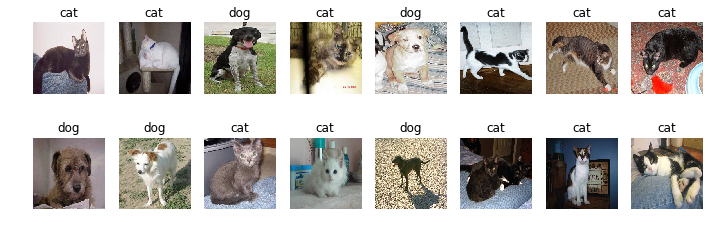

In [19]:
plot_batch(val_batch,val_labels,classes)

In [22]:
train_batch.shape

(16, 256, 256, 3)

In [23]:
from keras.applications.vgg16 import VGG16

In [24]:
image_shape = train_batch.shape[1:]
vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=image_shape, pooling=None)

In [25]:
vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [26]:
from keras.layers import Flatten, Dense
from keras.models import Model

vgg16_top = vgg16_base.output
vgg16_top = Flatten()(vgg16_top)
# let's add a fully-connected layer
vgg16_top = Dense(1024, activation='relu')(vgg16_top)
# and a logistic layer -- let's say we have 2 classes
vgg16_top = Dense(1, activation='sigmoid')(vgg16_top)

# this is the model we will train
model = Model(inputs=vgg16_base.input, outputs=vgg16_top)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in vgg16_base.layers:
    layer.trainable = False

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [28]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
weights_file = path + '/dogs_vs_cats.h5'

In [25]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
num_batches = num_of_samples/batch_size
epochs = 10
steps_per_epoch = batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=3, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=0, mode='auto')
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', period=1)

# fine-tune the model
model.fit_generator(train_images, steps_per_epoch=num_batches, epochs=epochs, 
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    validation_data=val_images, validation_steps=10) 

Epoch 1/10
1313/1312 [==============================] - 385s - loss: 0.5565 - acc: 0.9547 - val_loss: 0.4696 - val_acc: 0.9625
Epoch 2/10
1313/1312 [==============================] - 335s - loss: 0.3350 - acc: 0.9724 - val_loss: 0.2400 - val_acc: 0.9812
Epoch 3/10
1313/1312 [==============================] - 337s - loss: 0.2163 - acc: 0.9819 - val_loss: 0.1529 - val_acc: 0.9875
Epoch 4/10
1313/1312 [==============================] - 337s - loss: 0.1736 - acc: 0.9856 - val_loss: 0.0117 - val_acc: 0.9938
Epoch 5/10
1313/1312 [==============================] - 312s - loss: 0.1200 - acc: 0.9898 - val_loss: 0.2106 - val_acc: 0.9812
Epoch 6/10
1313/1312 [==============================] - 312s - loss: 0.1011 - acc: 0.9917 - val_loss: 0.1754 - val_acc: 0.9812
Epoch 7/10
1313/1312 [==============================] - 312s - loss: 0.0730 - acc: 0.9945 - val_loss: 0.3036 - val_acc: 0.9625


## Model predictions

In [29]:
model.load_weights(weights_file)

In [30]:
test_generator = idg.flow_from_directory(path+test_dir, batch_size=16,
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

Found 12500 images belonging to 1 classes.


In [31]:
test_dataset_size = len(test_generator.filenames)
num_of_batches = test_dataset_size/batch_size
print(test_dataset_size)

12500


In [29]:
probabilities = model.predict_generator(test_generator, num_of_batches)

In [30]:
probabilities_clipped = np.clip(probabilities,0.001,0.999)

In [32]:
n1 = [s.split('/')[1] for s in test_generator.filenames]
n2 = [int(s.split('.')[0]) for s in n1]

In [33]:
results = {'id': np.array(n2), 'label': probabilities_clipped.transpose()[0]}

In [34]:
results

{'id': array([ 2957, 11706, 10629, ...,  2885,  8923,  8897]),
 'label': array([ 0.001     ,  0.99900001,  0.99900001, ...,  0.99900001,
         0.001     ,  0.99900001], dtype=float32)}

In [35]:
import pandas as pd

In [36]:
results = pd.DataFrame.from_dict(results)

In [37]:
results.head()

,id,label
0,2957,0.001
1,11706,0.999
2,10629,0.999
3,9810,0.001
4,9834,0.001


In [38]:
results.to_csv('test.csv')

In [ ]:
from IPython.display import FileLink
FileLink('test.csv')

## Run prediction on validation set

In [45]:
batch_size=64
class_mode=None
val_generator = idg.flow_from_directory(path_val, batch_size=batch_size, shuffle=False, class_mode=class_mode, classes=classes)

Found 4000 images belonging to 2 classes.


In [50]:
num_of_batches=np.ceil(4000/batch_size)
prob_val=model.predict_generator(val_generator, num_of_batches, verbose=True)

63/63 [==============================] - 58s    


In [51]:
result_dict = {'prob_val': np.squeeze(prob_val), 'filenames': val_images.filenames, 'class': val_images.classes}

In [5]:
import pandas as pd
import numpy as np

In [6]:
df_result = pd.DataFrame(result_dict)

NameError: name 'result_dict' is not defined

In [57]:
df_result.to_csv('Validation_results.csv')

In [7]:
df_result=pd.read_csv('Validation_results.csv', index_col=0, parse_dates=True)

In [8]:
df_cats_like_dogs = df_result[(df_result["class"]!=np.round(df_result["prob_val"])) & (df_result["class"]==0)]
df_dogs_like_cats = df_result[(df_result["class"]!=np.round(df_result["prob_val"])) & (df_result["class"]==1)]
df_cats_like_cats = df_result[(df_result["class"]==np.round(df_result["prob_val"])) & (df_result["class"]==0)]
df_dogs_like_dogs = df_result[(df_result["class"]==np.round(df_result["prob_val"])) & (df_result["class"]==1)]
df_confused = df_result.iloc[(df_result["prob_val"]-0.5).abs().argsort()[:16]]

In [58]:
import imp
import utils; imp.reload(utils)
from utils import plot_batch
from utils import plot_file_list

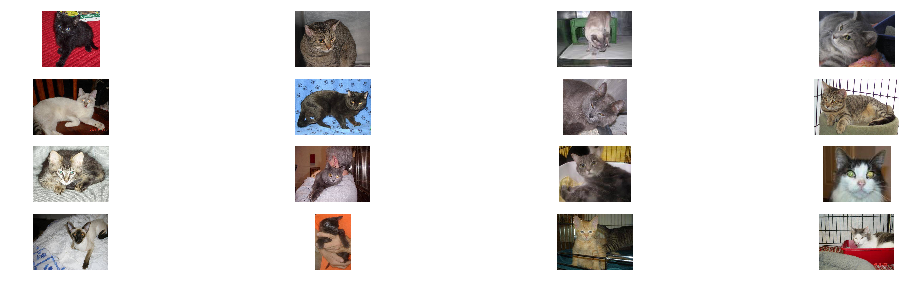

In [64]:
df_cats_like_dogs = df_result[(df_result["class"]!=np.round(df_result["prob_val"])) & (df_result["class"]==0)]
list_cats_like_dogs = df_cats_like_dogs["filenames"].sample(16).values
df_cats_like_dogs.head()
list_sample = []
for f in list_cats_like_dogs:
    f = "../data/val/"+f
    list_sample.append(f)
    
plot_images(list_sample)

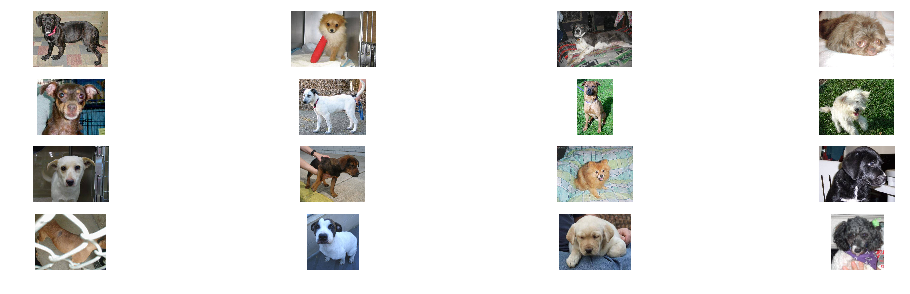

In [65]:
df_dogs_like_cats = df_result[(df_result["class"]!=np.round(df_result["prob_val"])) & (df_result["class"]==1)]
list_dogs_like_cats = df_dogs_like_cats["filenames"].sample(16).values
df_dogs_like_cats.head()
list_sample = []
for f in list_dogs_like_cats:
    f = "../data/val/"+f
    list_sample.append(f)
    
plot_images(list_sample)

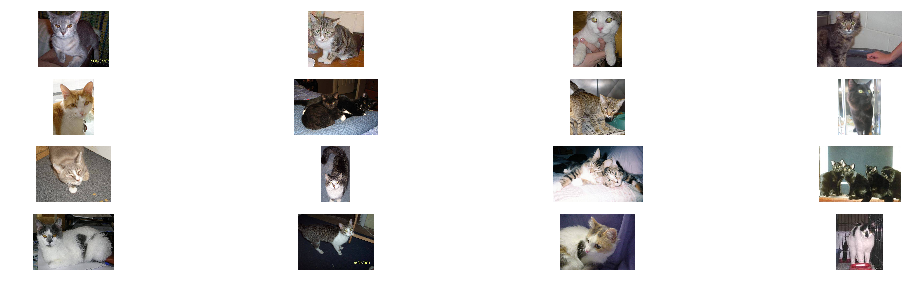

In [66]:
df_cats_like_cats = df_result[(df_result["class"]==np.round(df_result["prob_val"])) & (df_result["class"]==0)]
list_cats_like_cats = df_cats_like_cats["filenames"].sample(16).values
df_cats_like_cats.head()
list_sample = []
for f in list_cats_like_cats:
    f = "../data/val/"+f
    list_sample.append(f)
    
plot_images(list_sample)

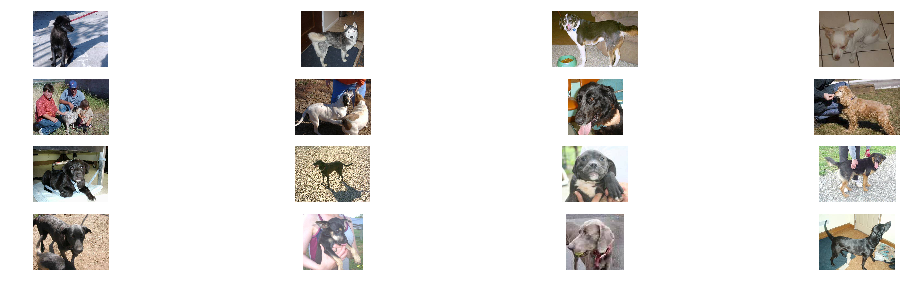

In [67]:
df_dogs_like_dogs = df_result[(df_result["class"]==np.round(df_result["prob_val"])) & (df_result["class"]==1)]
list_dogs_like_dogs = df_dogs_like_dogs["filenames"].sample(16).values
df_dogs_like_dogs.head()
list_sample = []
for f in list_dogs_like_dogs:
    f = "../data/val/"+f
    list_sample.append(f)
    
plot_images(list_sample)

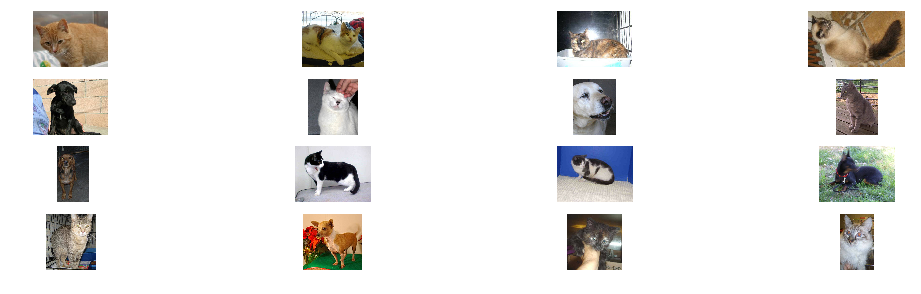

In [68]:
df_confused = df_result.iloc[(df_result["prob_val"]-0.5).abs().argsort()[:16]]
list_confused = df_confused["filenames"].sample(16).values
df_confused.head()
list_sample = []
for f in list_confused:
    f = "../data/val/"+f
    list_sample.append(f)
    
plot_images(list_sample)